In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
from sklearn.ensemble import IsolationForest, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from prophet import Prophet  # Install via: pip install prophet
import warnings
warnings.filterwarnings('ignore')


In [17]:
df = pd.read_csv("GlobalWeatherRepository.csv")

In [18]:
df.columns

Index(['country', 'location_name', 'latitude', 'longitude', 'timezone',
       'last_updated_epoch', 'last_updated', 'temperature_celsius',
       'temperature_fahrenheit', 'condition_text', 'wind_mph', 'wind_kph',
       'wind_degree', 'wind_direction', 'pressure_mb', 'pressure_in',
       'precip_mm', 'precip_in', 'humidity', 'cloud', 'feels_like_celsius',
       'feels_like_fahrenheit', 'visibility_km', 'visibility_miles',
       'uv_index', 'gust_mph', 'gust_kph', 'air_quality_Carbon_Monoxide',
       'air_quality_Ozone', 'air_quality_Nitrogen_dioxide',
       'air_quality_Sulphur_dioxide', 'air_quality_PM2.5', 'air_quality_PM10',
       'air_quality_us-epa-index', 'air_quality_gb-defra-index', 'sunrise',
       'sunset', 'moonrise', 'moonset', 'moon_phase', 'moon_illumination'],
      dtype='object')

In [19]:
df['last_updated'] = pd.to_datetime(df['last_updated'])

df = df.sort_values('last_updated').reset_index(drop=True)

In [20]:
print("Data Head:")
print(df.head())
print("\nData Info:")
print(df.info())
print("\nMissing Values:")
print(df.isnull().sum())


Data Head:
                    country    location_name  latitude  longitude  \
0  United States of America  Washington Park     46.60    -120.49   
1               El Salvador     San Salvador     13.71     -89.20   
2                Costa Rica         San Juan      9.97     -84.08   
3                 Guatemala   Guatemala City     14.62     -90.53   
4                 Nicaragua          Managua     12.15     -86.27   

              timezone  last_updated_epoch        last_updated  \
0  America/Los_Angeles          1715849100 2024-05-16 01:45:00   
1  America/El_Salvador          1715849100 2024-05-16 02:45:00   
2   America/Costa_Rica          1715849100 2024-05-16 02:45:00   
3    America/Guatemala          1715849100 2024-05-16 02:45:00   
4      America/Managua          1715849100 2024-05-16 02:45:00   

   temperature_celsius  temperature_fahrenheit  \
0                 16.1                    61.0   
1                 26.0                    78.8   
2                 21.0     

## Advanced Exploratory Data Analysis (EDA)

In [21]:
print("\nDescriptive Statistics:")
print(df.describe())


Descriptive Statistics:
           latitude     longitude  last_updated_epoch  \
count  60218.000000  60218.000000        6.021800e+04   
mean      19.136183     22.183266        1.729268e+09   
min      -41.300000   -175.200000        1.715849e+09   
25%        3.750000     -6.836100        1.722602e+09   
50%       17.250000     23.316700        1.729329e+09   
75%       40.400000     50.580000        1.735986e+09   
max       64.150000    179.220000        1.742637e+09   
std       24.475796     65.815106        7.777921e+06   

                        last_updated  temperature_celsius  \
count                          60218         60218.000000   
mean   2024-10-18 18:28:04.828456704            22.160778   
min              2024-05-16 01:45:00           -24.900000   
25%              2024-08-02 19:30:00            16.900000   
50%              2024-10-19 05:22:30            25.000000   
75%              2025-01-04 12:15:00            28.400000   
max              2025-03-22 22:45:

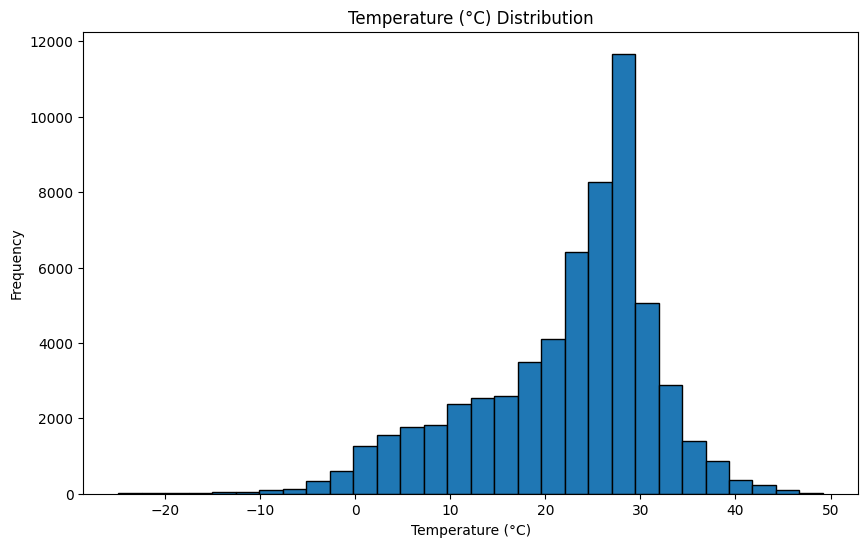

In [22]:
plt.figure(figsize=(10, 6))
plt.hist(df['temperature_celsius'].dropna(), bins=30, edgecolor='black')
plt.title("Temperature (°C) Distribution")
plt.xlabel("Temperature (°C)")
plt.ylabel("Frequency")
plt.show()

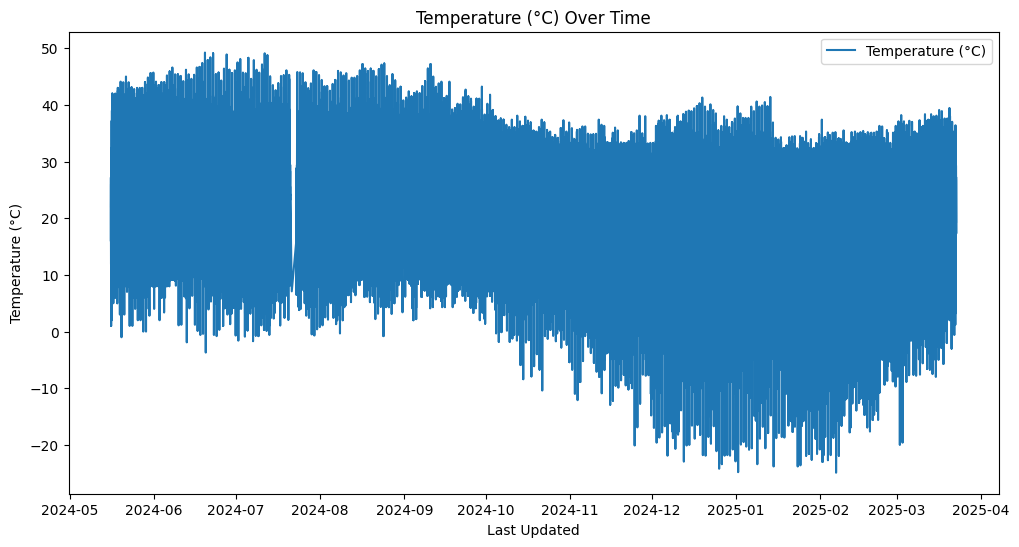

In [23]:
plt.figure(figsize=(12, 6))
plt.plot(df['last_updated'], df['temperature_celsius'], label='Temperature (°C)')
plt.xlabel("Last Updated")
plt.ylabel("Temperature (°C)")
plt.title("Temperature (°C) Over Time")
plt.legend()
plt.show()

# Anomaly Detection using IsolationForest


Number of detected anomalies in temperature_celsius: 595


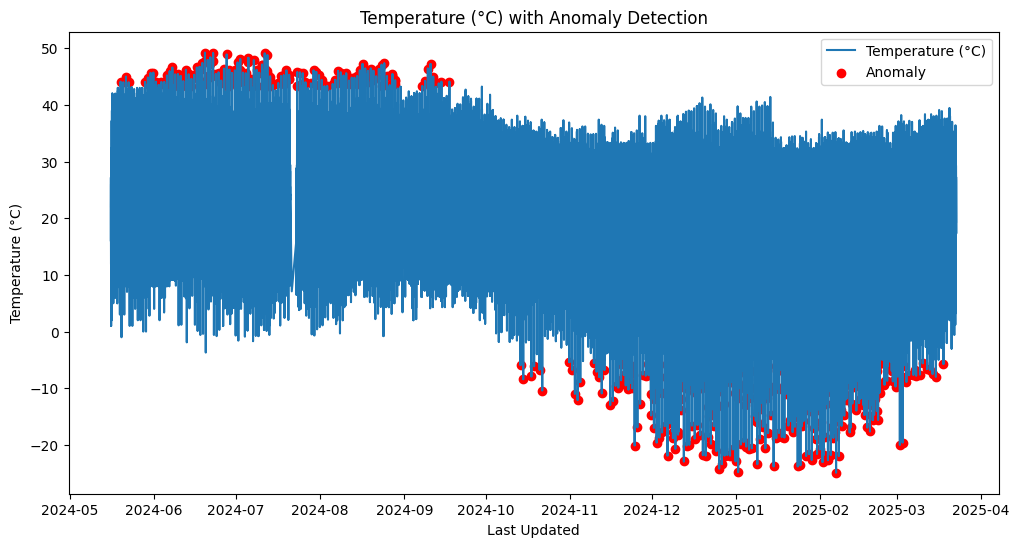

In [24]:
temp_values = df[['temperature_celsius']].dropna()

# Initialize and fit the IsolationForest model
iso_forest = IsolationForest(contamination=0.01, random_state=42)
df.loc[temp_values.index, 'anomaly_flag'] = iso_forest.fit_predict(temp_values)

# Flag anomalies where the prediction equals -1
df['Anomaly'] = df['anomaly_flag'].apply(lambda x: True if x == -1 else False)
print("\nNumber of detected anomalies in temperature_celsius:", df['Anomaly'].sum())

# Visualize detected anomalies on the time series plot
plt.figure(figsize=(12, 6))
plt.plot(df['last_updated'], df['temperature_celsius'], label='Temperature (°C)')
plt.scatter(df.loc[df['Anomaly'], 'last_updated'], df.loc[df['Anomaly'], 'temperature_celsius'],
            color='red', label='Anomaly')
plt.xlabel("Last Updated")
plt.ylabel("Temperature (°C)")
plt.title("Temperature (°C) with Anomaly Detection")
plt.legend()
plt.show()

In [25]:
df_clean = df[df['Anomaly'] == False].copy()
print("\nData shape after removing outliers:", df_clean.shape)


Data shape after removing outliers: (59623, 43)


# Forecasting with Multiple Models

 forecasting  'temperature_celsius' using two models ARIMA ,Prophet and then build an ensemble forecast.

preparing time series data

In [26]:
if 'Date' not in df_clean.columns:
    df_clean['Date'] = df_clean['last_updated']

# ----------------------
# Prepare Time Series Data
# ----------------------
# Group by 'Date' to ensure unique daily values
ts = df_clean.groupby('Date')['temperature_celsius'].mean()

# Enforce daily frequency and fill missing dates using forward-fill
ts = ts.asfreq('D')
ts = ts.fillna(method='ffill')

# Prophet requires a DataFrame with columns 'ds' and 'y'
prophet_df = ts.reset_index().rename(columns={'Date': 'ds', 'temperature_celsius': 'y'})

# Define forecast horizon (e.g., 30 days)
forecast_horizon = 30


# Model 1: ARIMA Forecasting

In [27]:
arima_order = (5, 1, 0)
arima_model = sm.tsa.ARIMA(ts, order=arima_order)
arima_result = arima_model.fit()
arima_forecast = arima_result.forecast(steps=forecast_horizon)

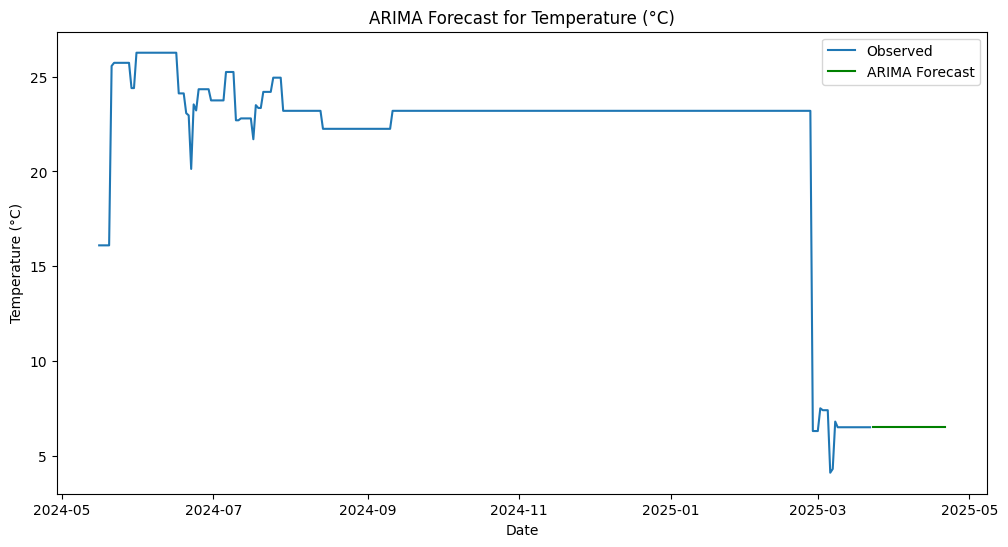

In [28]:
plt.figure(figsize=(12, 6))
plt.plot(ts.index, ts, label='Observed')
plt.plot(arima_forecast.index, arima_forecast, label='ARIMA Forecast', color='green')
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.title("ARIMA Forecast for Temperature (°C)")
plt.legend()
plt.show()

# Model 2: Prophet Forecasting

In [29]:
m = Prophet()
m.fit(prophet_df)
future = m.make_future_dataframe(periods=forecast_horizon)
forecast = m.predict(future)

# Extract forecast for the target horizon from Prophet's results
prophet_forecast = forecast[['ds', 'yhat']].set_index('ds').tail(forecast_horizon)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnc2m6xjj/z4a0ve67.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnc2m6xjj/68kx1cyn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15066', 'data', 'file=/tmp/tmpnc2m6xjj/z4a0ve67.json', 'init=/tmp/tmpnc2m6xjj/68kx1cyn.json', 'output', 'file=/tmp/tmpnc2m6xjj/prophet_model6una09uq/prophet_model-20250324050613.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:06:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:06:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


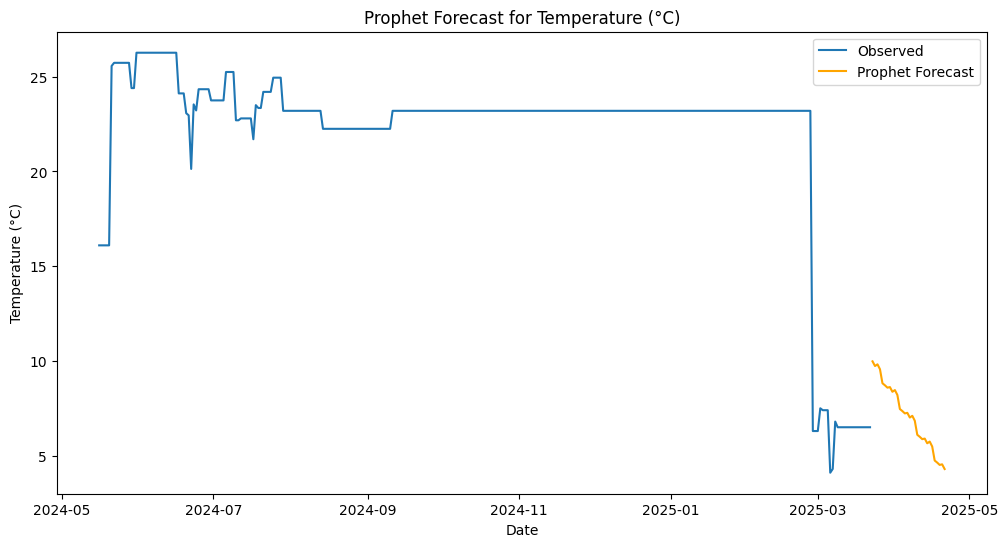

In [30]:
plt.figure(figsize=(12, 6))
plt.plot(prophet_df['ds'], prophet_df['y'], label='Observed')
plt.plot(prophet_forecast.index, prophet_forecast['yhat'], label='Prophet Forecast', color='orange')
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.title("Prophet Forecast for Temperature (°C)")
plt.legend()
plt.show()

# Ensemble Forecast: Averaging ARIMA and Prophet Predictions

In [31]:
ensemble_forecast = pd.DataFrame({
    'ARIMA': arima_forecast,
    'Prophet': prophet_forecast['yhat']
})
ensemble_forecast['Ensemble'] = ensemble_forecast.mean(axis=1)

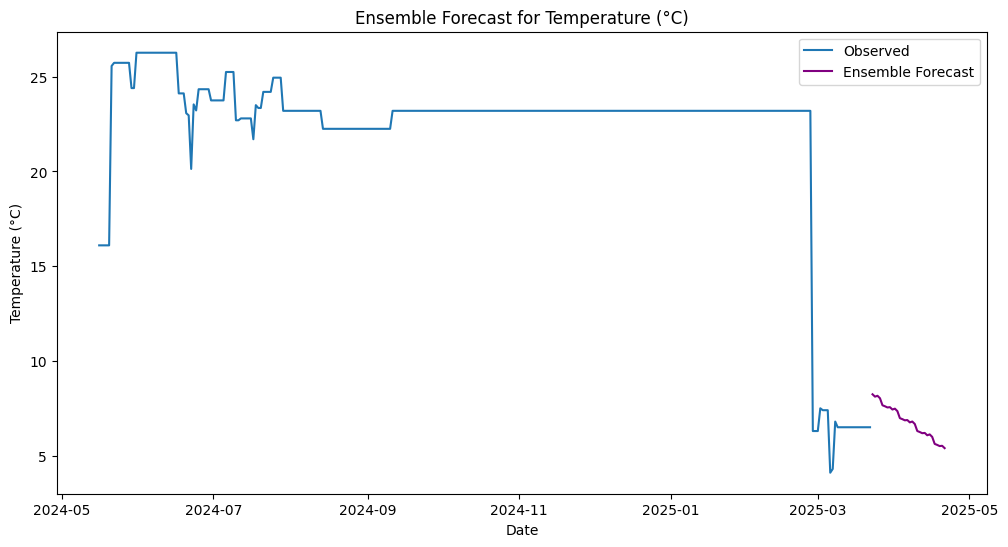

In [32]:
plt.figure(figsize=(12, 6))
plt.plot(ts.index, ts, label='Observed')
plt.plot(ensemble_forecast.index, ensemble_forecast['Ensemble'], label='Ensemble Forecast', color='purple')
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.title("Ensemble Forecast for Temperature (°C)")
plt.legend()
plt.show()

#6.Unique Analyses

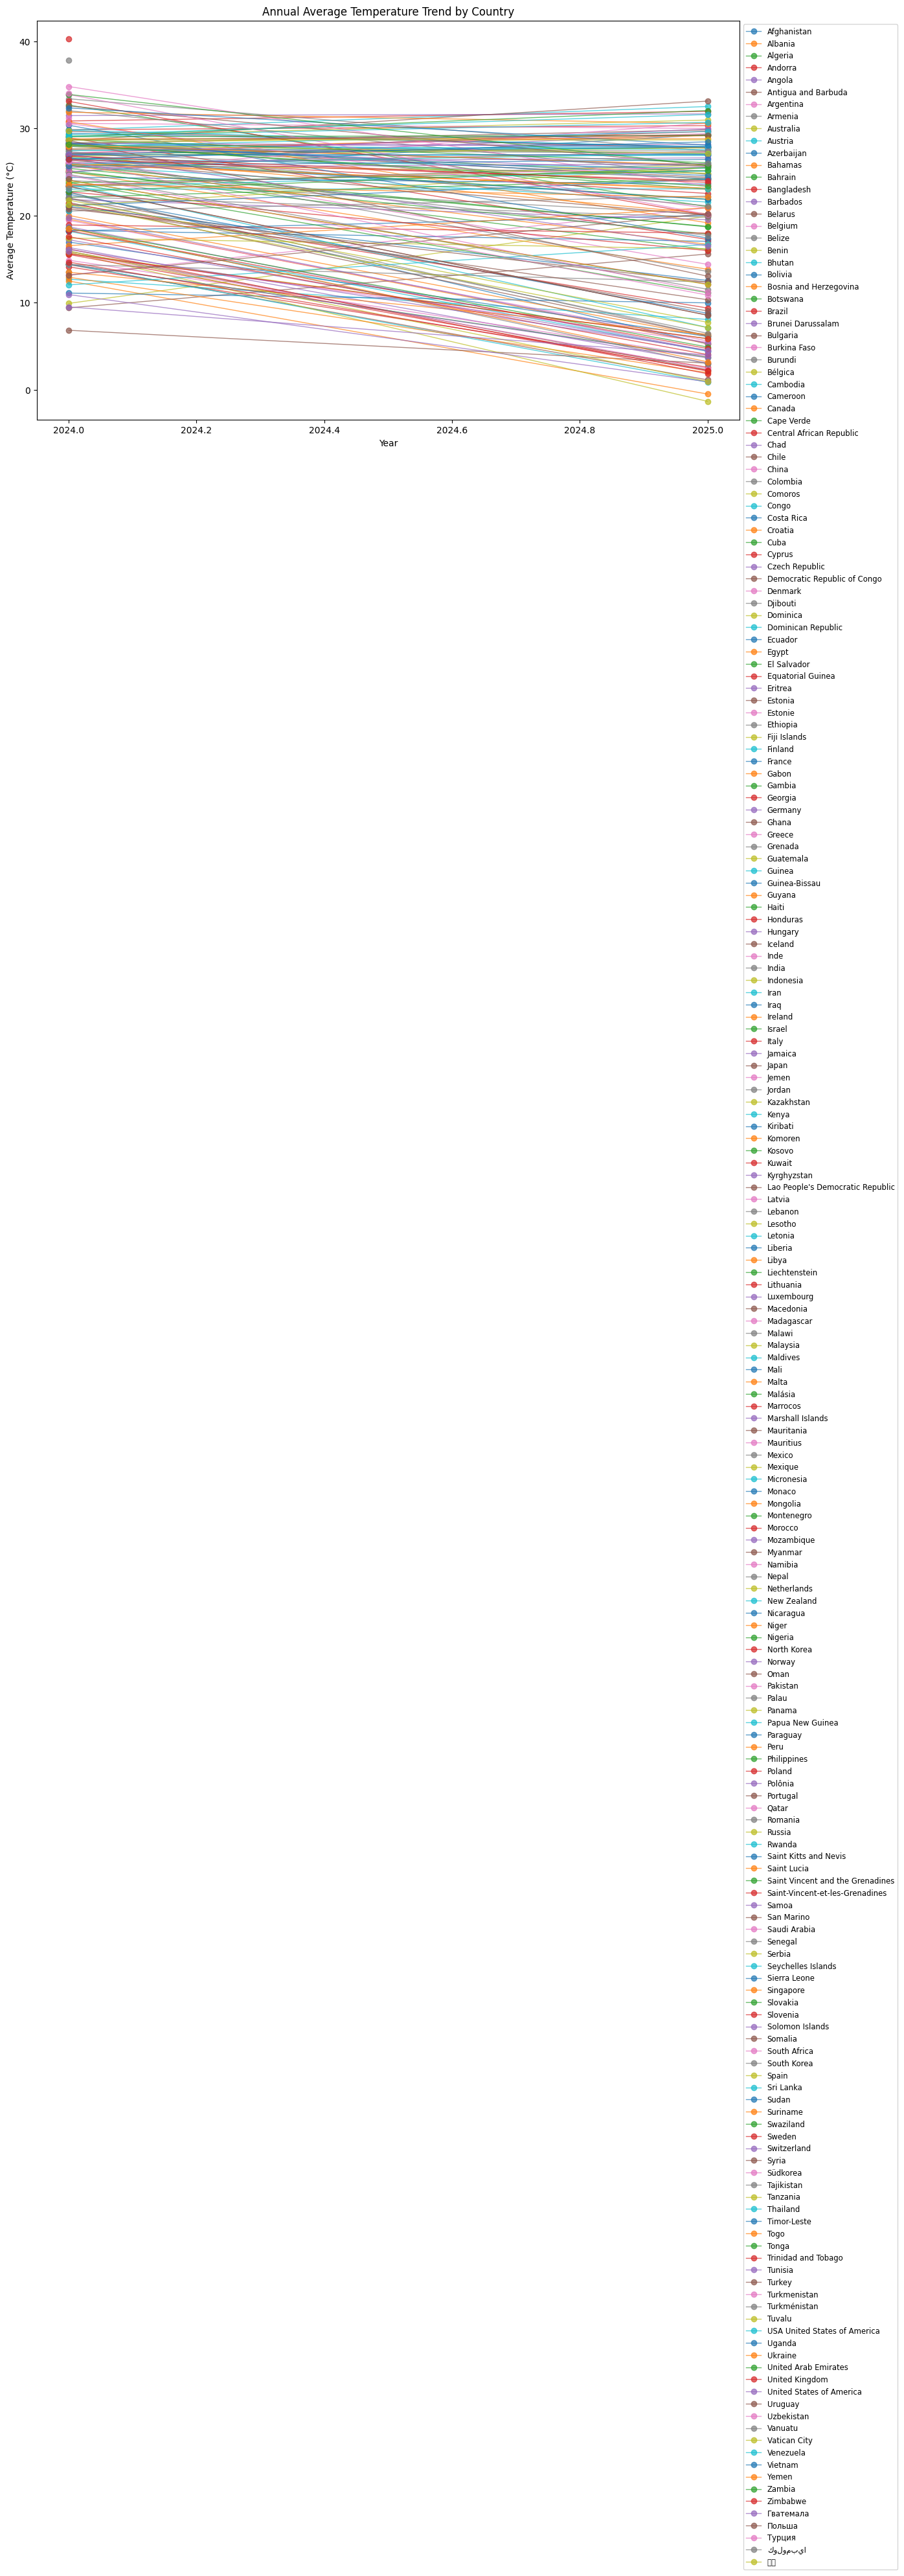

In [41]:

df_clean['Year'] = df_clean['Date'].dt.year
climate_trend = df_clean.groupby(['country', 'Year'])['temperature_celsius'].mean().reset_index()

# Get list of unique countries
countries = climate_trend['country'].unique()

plt.figure(figsize=(14, 8))

for country in countries:
    country_data = climate_trend[climate_trend['country'] == country]
    plt.plot(country_data['Year'], country_data['temperature_celsius'], marker='o', linewidth=1, alpha=0.7, label=country)

plt.xlabel("Year")
plt.ylabel("Average Temperature (°C)")
plt.title("Annual Average Temperature Trend by Country")
# For many countries, the legend may be too crowded. You can comment it out or show a subset.
plt.legend(fontsize='small', loc='upper left', bbox_to_anchor=(1, 1), ncol=1)
plt.tight_layout()
plt.show()



Correlation Matrix:
                     air_quality_PM2.5  temperature_celsius  humidity  \
air_quality_PM2.5             1.000000            -0.058989 -0.139543   
temperature_celsius          -0.058989             1.000000 -0.334468   
humidity                     -0.139543            -0.334468  1.000000   
pressure_mb                   0.036696            -0.263617 -0.005864   
wind_mph                     -0.044727             0.062203 -0.062402   

                     pressure_mb  wind_mph  
air_quality_PM2.5       0.036696 -0.044727  
temperature_celsius    -0.263617  0.062203  
humidity               -0.005864 -0.062402  
pressure_mb             1.000000 -0.052927  
wind_mph               -0.052927  1.000000  


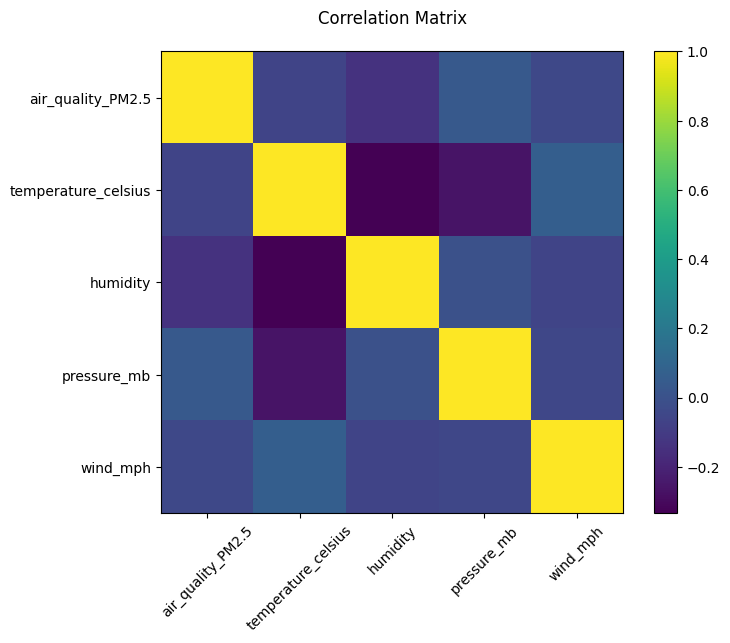

In [42]:
cols_for_corr = ['air_quality_PM2.5', 'temperature_celsius', 'humidity', 'pressure_mb', 'wind_mph']
corr_matrix = df_clean[cols_for_corr].corr()
print("\nCorrelation Matrix:")
print(corr_matrix)

plt.figure(figsize=(8, 6))
plt.imshow(corr_matrix, cmap='viridis', interpolation='none')
plt.colorbar()
plt.xticks(range(len(cols_for_corr)), cols_for_corr, rotation=45)
plt.yticks(range(len(cols_for_corr)), cols_for_corr)
plt.title("Correlation Matrix", pad=20)
plt.show()


# Assessing Predictors for Temperature

In [37]:
features = ['humidity', 'pressure_mb', 'wind_mph', 'air_quality_PM2.5']
df_model = df_clean.dropna(subset=features + ['temperature_celsius'])

X = df_model[features]
y = df_model['temperature_celsius']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("\nRandom Forest Mean Squared Error:", mse)

importances = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)
print("\nFeature Importances:")
print(importances)


Random Forest Mean Squared Error: 33.646553965160216

Feature Importances:
pressure_mb          0.421895
humidity             0.278364
air_quality_PM2.5    0.176891
wind_mph             0.122849
dtype: float64


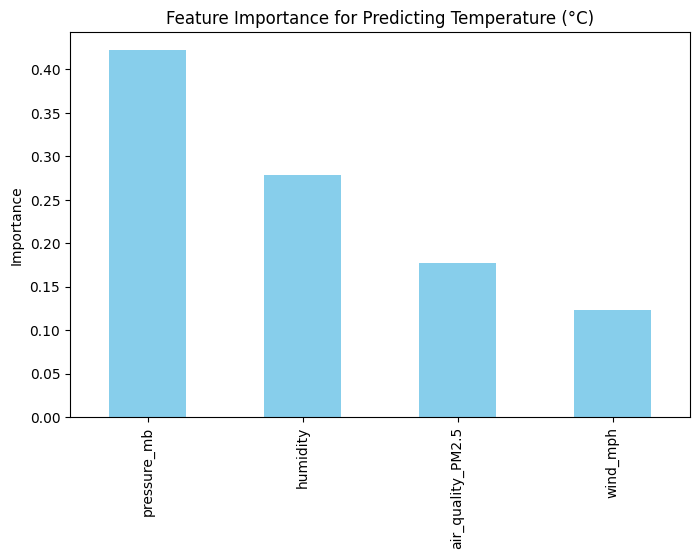

In [38]:
plt.figure(figsize=(8, 5))
importances.plot(kind='bar', color='skyblue')
plt.ylabel("Importance")
plt.title("Feature Importance for Predicting Temperature (°C)")
plt.show()

# Spatial Analysis: Visualizing Geographical Patterns
Use latitude and longitude to display temperature distribution.

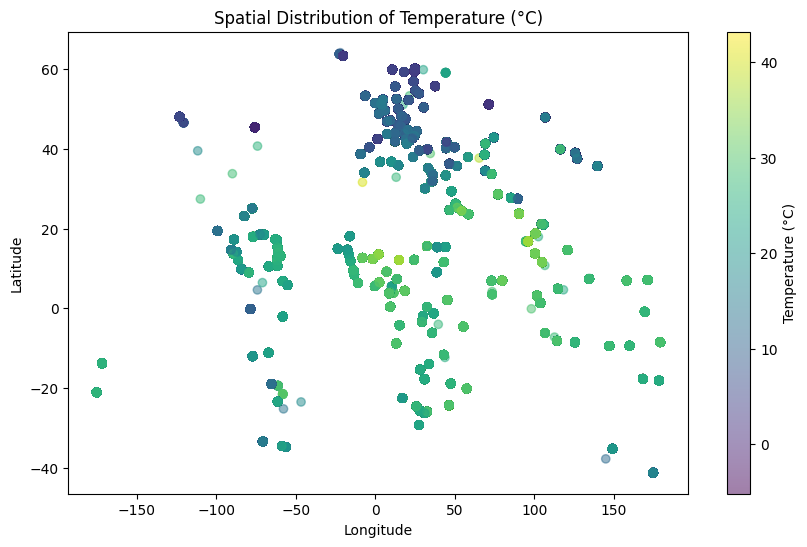

In [39]:
plt.figure(figsize=(10, 6))
plt.scatter(df_clean['longitude'], df_clean['latitude'],
            c=df_clean['temperature_celsius'], cmap='viridis', alpha=0.5)
plt.colorbar(label='Temperature (°C)')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Spatial Distribution of Temperature (°C)")
plt.show()

# Compareing Average Temperature by Country

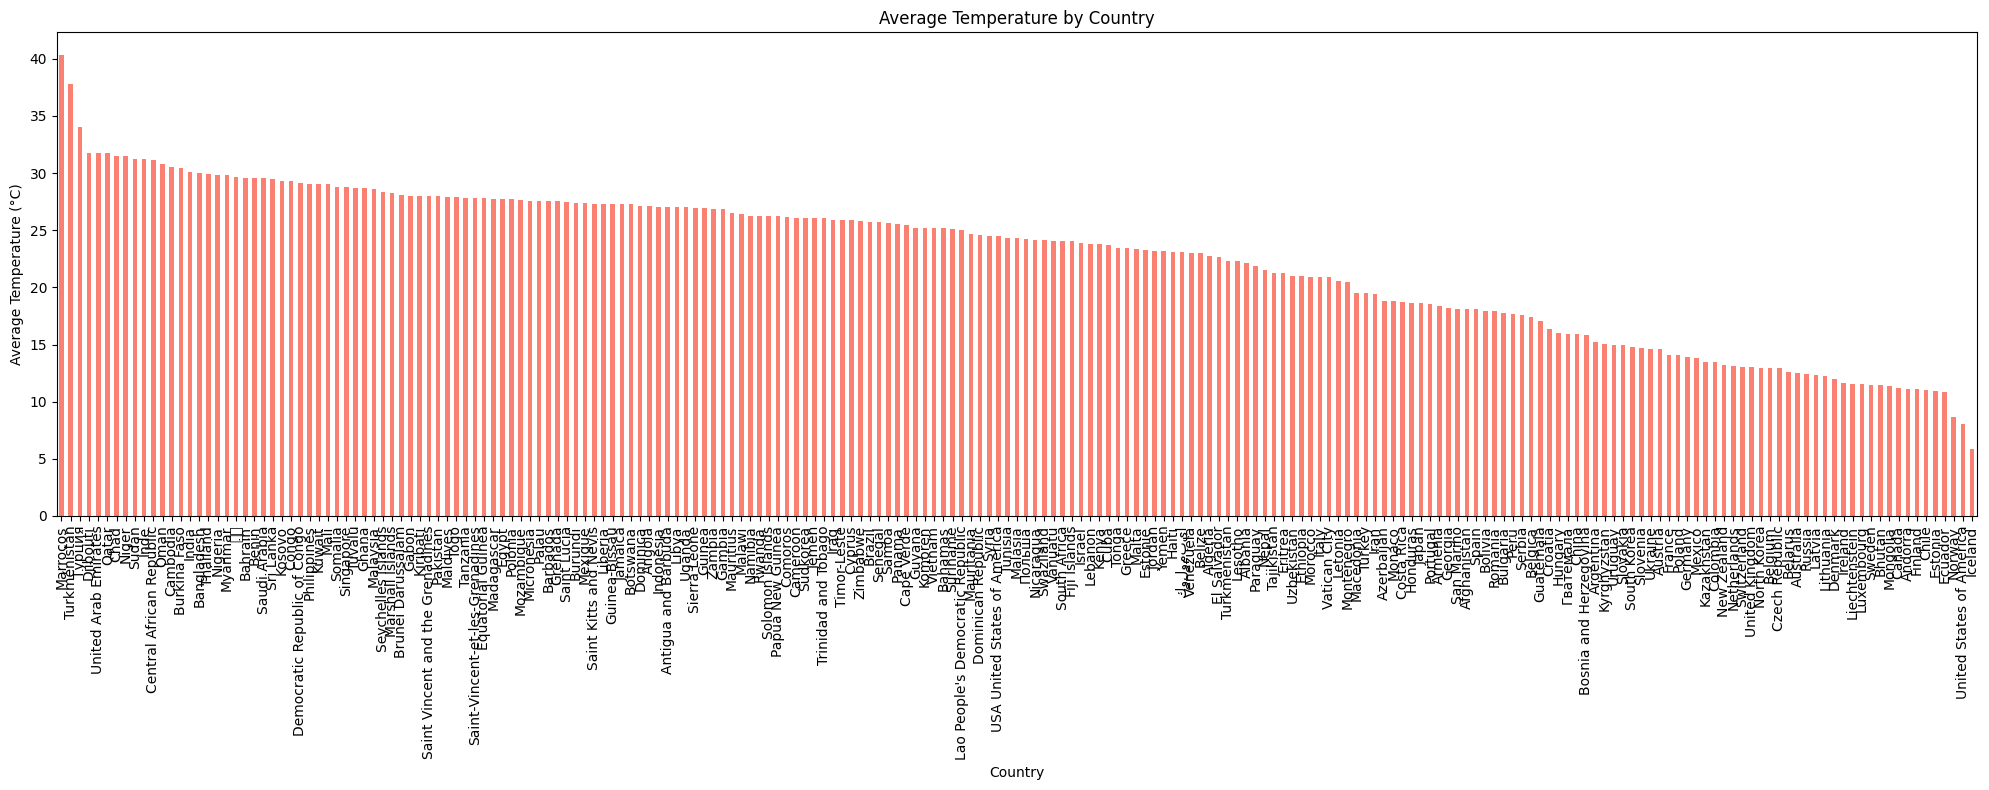

In [43]:
country_temp = df_clean.groupby('country')['temperature_celsius'].mean().sort_values(ascending=False)
plt.figure(figsize=(20, 8))
country_temp.plot(kind='bar', color='salmon')
plt.xlabel("Country")
plt.ylabel("Average Temperature (°C)")
plt.title("Average Temperature by Country")
plt.tight_layout()
plt.show()